# Termites

This notebook explores a type of Turing Machine known as [termites](https://en.wikipedia.org/wiki/Turmite). The first part is a script I wrote a few years ago when I was first learning Python. If you are new to learning Python, I suggest you give it a try before reading the script; there's a lot you will learn about flow control and data structures. My script is far from perfect and every time I come back to it there is an idiom I can add and areas that can be refactored and cleaned up. It generates images of 2-dimensional n-state termites on an $a$ x $b$ rectangular grid, or it can generate multiple images (frames) of a single termite as it grows to make a video. Here's an example of a termite animatino that I made using the script below:

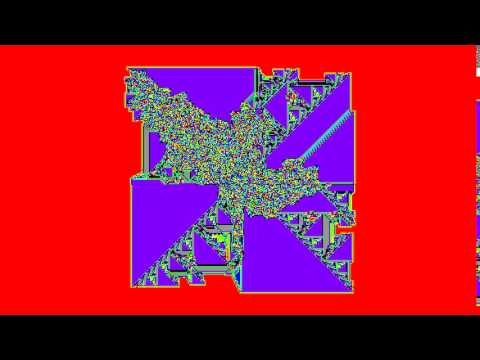

In [285]:
from IPython.display import YouTubeVideo
YouTubeVideo('Du2DorTLAo4', width=1920/2, height=1080/2)

The type of termite explored here is a modified version of a type of cellular automata known as [Langton's Ant](https://en.wikipedia.org/wiki/Langton%27s_ant). Langton's Ant has a simple ruleset: an ant is placed on a 2-dimensional grid of 2-state cells (black or white) with a directional orientation. If the ant is on a black cell at $t=n$, the ant enters the cell on the immediate left at $t=n+1$ and the state of the cell it exits changes to white. If the state of the cell that the ant enters is white, the ant enters the cell immediately to the right and the cell it exits turns black. Around 11,000 steps, the ant enters a 'highway' which results in a repeated motion that moves the ant continually in one direction. 

Instead of black and white cells, we can define $n$ number of states (colors) and assign any combination of $n$ instructions (eg. LRLLLRLLLRL). The script below generates generates an arbitrary number of `ants`. Each number in `range(ants)` is converted to binary and then 1s and 0s of the corresponding binary number represent the left and right turns for each individual ant. For example: `bin(23)` corresponds to a 5-state ant with the following rules: RLRRR. This method avoids generating isotropes (RLRRR is the same ant as LRLLL). 

If `record` is set to `True`, one frame will be captured every `frame_interval` number of steps. These images can be converted into video easily with open-source programs like [Blender](https://www.blender.org/). 

The last part of the notebook attempts to use new methods from the latest version of scikit-learn ([0.18.1](http://scikit-learn.org/stable/whats_new.html)) to cluster ants by their behavior: k-means (for clustering) and Isolation Forests (for detecting outliers). 

In [97]:
import PIL
from PIL import Image
import random
import os
import sys
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
from __future__ import print_function
from sklearn import cluster
import seaborn as sns
%matplotlib inline

In [ ]:
#this script generates an image (or a series of images) for n-state 2D Langton's Ant cellular automaton. 

#SETTINGS

#number of ants to run
ants = 65536
#ants = 100
#set record to True to record frames once every frame_interval steps
record = False
frame_interval = 5000

#Boolean for recording final image
record_final_image = False

#set scale to scale the resulting images in save_image(i) function
scale = 1

#set the length and width of the square image canvas
width = int(200)
length = int(200)

#initialize ant in the center of the grid
#grid contains length_width**2 cells
ant_pos = int((length*width)/2) + int(width/2) 

#boolean to check if the ant touches the border (out of bounds)
oob = False

#number of steps that the ant will take on each walk
iterations = 100000

#for naming the image file below
number = str(iterations)

#set the direction of the ant's first step: 1 --> Right; -1 --> Left. Eliminates mirror images (isotropes) from dataset
direction = 1

#Ininitialize a blank square image
im1 = Image.new('RGBA', (width,length),'white')

#color selection
white = (255,255,255,255)
red = (255,0,0,255)
orange = (255,128,0,255)
yellow = (255,255,0,255)
yellow_green = (128,255,0,255)
green = (0,255,0,255)
teal = (0,255,255,255)
light_blue = (0,128,255,255)
blue = (0,0,255,255)
purple = (127,0,255,255)
black = (0,0,0,255)
grey = (150,150,150,255)
other = (40,100,50,255)
brown = (130,90,44,255)
pink = (244,114,208,255)
mauve = (118,96,138,255)
magenta = (216,0,115,255)

color_choices = [red, orange, yellow, light_blue, yellow_green, blue, purple, black, grey, green, teal, light_blue, other, brown, pink, mauve, magenta]

#convert an integer to binary and then convert 
def num_to_string(num):
    binary = bin(num)
    moves = ""
    for x in str(binary)[2:]:
        if x == '1':
            moves += "R"
        else:
            moves += "L"
    return moves

#moves list includes all 16 length moves
#moves_list = [num_to_string(ant) for ant in range(32768,65536)] 

#defines the list of strings that is used for the main loop bellow
moves_list = [num_to_string(ant) for ant in range(ants)]

#a list of the dictionaries to by passed into the pandas dataframe for later analysis
df_row_list = []

#dataframe object for later analysis
df = pd.DataFrame() #index=[0]

#functions for moving the postition of the ant right, left, up or down
def move_right():
    global ant_pos
    #move ant_pos one pixel to the right
    ant_pos += 1
    return ant_pos
def move_left():
    global ant_pos
    #move ant_pos one pixel to the left
    ant_pos -= 1
    return ant_pos
def move_up():
    global ant_pos
    #move ant_pos one pixel up
    ant_pos += width
    return ant_pos
def move_down():
    global ant_pos
    #move ant_pos one pixel down
    ant_pos -= width
    return ant_pos

def move(color,d):
    global direction
    while True:
        #this part is a little confusing and may need to be rewritten
        #it uses the current direction of the ant to determine the appropriate direction for the next turn
        #breaks are used 
        if pix_list[ant_pos][2] == color and direction == width*d:
            #set the color to the next color in the list, or loop back to the beginning of the list if the end has been reached
            pix_list[ant_pos][2] = (color + 1) % len(pixel_colors)
            #save the current postion of the ant
            init = ant_pos
            #move the ant
            move_right()
            #save the updated position of the ant 
            end = ant_pos
            #calculate the new direction of the ant by taking the difference between end and init
            direction = end - init
            break

        #same idea as above
        elif pix_list[ant_pos][2] == color and direction == -1*width*d:
            pix_list[ant_pos][2] = (color + 1) % len(pixel_colors)
            init = ant_pos
            move_left()
            end = ant_pos
            direction = end - init
            break
        #same idea as above
        elif pix_list[ant_pos][2] == color and direction == 1*d:
            pix_list[ant_pos][2] = (color + 1) % len(pixel_colors)
            init = ant_pos
            move_down()
            end = ant_pos
            direction = end - init
            break
        #same idea as above
        elif pix_list[ant_pos][2] == color and direction == -1*d:
            pix_list[ant_pos][2] = (color + 1) % len(pixel_colors)
            init = ant_pos
            move_up()
            end = ant_pos
            direction = end - init
            break
        break

#captures series of pixels used for generating images
def get_pix_series():
    global pix_series
    pix_series = []
    for x in range(len(pix_list)):
        for y in range(len(pixel_colors)):
            if pix_list[x][2] == y:
                pixel = pixel_colors[y]
                pix_series.append(pixel)

#runs ant along the grid according to the moves (defined above) for the number of steps in iterations (defined above)
def run():
    #variable the tracks the step number if the ant goes out of bounds
    global oob
    #converts moves string into a list of 0s and 1s; these numbers correspond to direction and are passed into the move() function
    moves1 = [1 if x == 'R' else -1 for x in moves]
    for step in range(iterations):
        #exit the loop if the ant reaches the edge of the grid
        if ant_pos < width or ant_pos % width == 0:
            oob = step
            return
        #loop through the moves 
        for index, direction in enumerate(moves1):
            try:
                #remember the ant position
                not_moved = ant_pos
                #try to move the ant position
                move(index,direction)
                #check to see if the position was moved
                if ant_pos != not_moved:
                    #set record to false in the settings to turn of frame recording
                    if record == True:
                        #records a new frame every frame_interval frame
                        if step % frame_interval == 0:
                            counter += 1
                            print("Generating frame number " + str(counter))
                            get_pix_series()
                            save_image(counter)
                    break
                else:
                    continue
            except: 
                #print("Out of bounds at step number " + str(step))
                oob = step
                return

def save_image(i):
    #give access to the image instantiated at the beginning of the script
    global im1
    #fill blank image canvas with pix_series pixel data
    im1.putdata(pix_series)
    #to rescale the image, set the scale variable in settings and call resize on im1
    im1.resize((scale*im1.size[0],scale*im1.size[1])).save('%s.png' % (moves))
    
#builds a dictionary to count pixels by color 
def build_df_row():
    colors_dict = {str(val): 0 for val, color in enumerate(pixel_colors)}
    moves_dict = {'moves':moves}
    last_step = {'last_step':oob}
    row_dict = dict(colors_dict.items()+moves_dict.items()+last_step.items())
    for x in pix_list:
        pixel_color = str(x[2])
        #print(pixel_color)
        row_dict[pixel_color] += 1
    return row_dict

#uncomment below to overwrite moves_list
#moves_list = ['LR', 'RRLR']

for _, moves in enumerate(moves_list):
    oob = 0
    dir_path = str(_)
    
    #make a new directory for each new ant walk in walks based on the the walk number and navigate to that directory
    if record == True:
        #make a new directory to record frames for a give ant if record is set to true and that directory does not yet exist
        if not os.path.isdir(dir_path):
            os.makedirs(dir_path)
        #otherwise just change into the directory
        else:
            os.chdir(dir_path)
    
    #set ant at middle of grid
    ant_pos = int((length*width)/2) + int(width/2) 
    
    #moves = len(moves)
    pixel_colors = color_choices[:(len(moves))]
    
    #defines an empty list of elements [x,y,0] where x amd y are the position 0 is the 0ht color in the color list (the base canvas color)
    pix_list = []
    for x in range(length):
        for y in range(width):
            a = [x,y,0]
            pix_list.append(a)

    #pix_series is a list of pixels that is passed into the put_data function to generate an image
    pix_series = []

    #counter keeps track of the frame number (if recording a series of images)
    counter = 0
    
    #run the ant
    run() 
    
    #capture the final state of the grid with get_pix_series
    get_pix_series()
    
    #uncomment below to preview images for testing
    #im1.putdata(pix_series)
    #im1.resize((scale*im1.size[0],scale*im1.size[1])).show()
    
    #build a dictionary with pixel counts
    colors_dict = build_df_row()
    row_df = pd.DataFrame(colors_dict, index=[0])
    df = df.append(row_df, ignore_index=True)
    
    if record_final_image == True:
        os.chdir(os.path.expanduser('~/Documents/CA_1/imgs/'))
        save_image(_)
        os.chdir('../')
    
    #summary
    print(str(_), end=' ')
    
os.chdir(os.path.expanduser('~/Documents/CA_1/'))
df.to_csv('ants_hist_.csv', index=False)

# Clustering

We now have a csv file where each row is a 16-state termite and the columns labeled 0 through 15 count the sum of pixels in each state (the different colors). With `last_step` we also track the last step reached in the event that the ant runs into the edge of the grid. This will be helpful in clustering ants that form highways in different groups from those that complete 100000 steps inside the 200 x 200 grid. 

First let's read the csv into a pandas DataFrame and look at some of the data. 

In [4]:
import PIL
from PIL import Image
import random
import os
import sys
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
from __future__ import print_function
from sklearn import cluster
import seaborn as sns
%matplotlib inline

In [37]:
os.chdir(os.path.expanduser('~/Documents/CA_1/'))
df1 = pd.read_csv('ants_hist_.csv')

In [38]:
df1.shape

(32768, 18)

In [39]:
df1.sample(3)

0    1   10   11   12   13   14   15    2    3    4    5    6    7  \
25892  37741  212  135  148  135  152  119  115  176  168  129  182  155  130   
27264  35861  117  444  421  497  395  327  222  345  143  126  218  241  187   
10181  37202  300  177  130  150  148  124  156  191  217  234  217  162  200   

         8    9  last_step             moves  
25892  162  141          0  RRRLLRLRLLRLLRLL  
27264  135  321          0  RRRLRLRLRLLLLLLL  
10181  222  170          0  RLRLLRRRRRLLLRLR

There are 32768 unique instructions for 16-state termites `(2^16)/2 = 32768`. Let's check to see how many of these are duplicates. We want to select only the state-counts and then call `.drop_duplicates` on that DataFrame. 

In [40]:
df2 = df1.iloc[:,0:16]

In [41]:
df2.shape[0] - df2.drop_duplicates().shape[0]

1566

1566 of the 16-state termites. It might be helpful to remove these termites from the DataFrame before we cluster them. 

In [42]:
unique_termites_index = df2.drop_duplicates().index

In [43]:
df = df1.loc[unique_termites_index,:]

In [44]:
df['steps_taken'] = [100000 if x==0 else x for x in df.last_step]
df['file_names'] = [x+'.png' for x in df.moves]
df['move_len'] = [len(x) for x in df.moves]

In [45]:
df.head()

0    1  10  11  12   13   14   15     2    3   ...      5   6   7   8  \
0  36381  584  36  32  41   85  179  174  1864  325   ...     45  45  32  31   
1  39857   44   4   0   6    0    0    4    27   17   ...      8   3  11   6   
2  39804   48   5  12   7    9    7    0    24   12   ...     11   9   7  20   
3  37223  346  70  97  89  122  100  124  1150  216   ...     85  83  61  60   
4  39678   76  22  16  17    8    1    2    47   17   ...     31  14  15  26   

    9  last_step             moves steps_taken            file_names move_len  
0  37          0  RLLLLLLLLLLLLLLL      100000  RLLLLLLLLLLLLLLL.png       16  
1   4          0  RLLLLLLLLLLLLLLR      100000  RLLLLLLLLLLLLLLR.png       16  
2   5          0  RLLLLLLLLLLLLLRL      100000  RLLLLLLLLLLLLLRL.png       16  
3  55          0  RLLLLLLLLLLLLLRR      100000  RLLLLLLLLLLLLLRR.png       16  
4  11          0  RLLLLLLLLLLLLRLL      100000  RLLLLLLLLLLLLRLL.png       16  

[5 rows x 21 columns]

In [46]:
df.index = df.file_names

Here's a quick look at the distribution of the base canvas color (red in the images below) over all of the unique termites. 

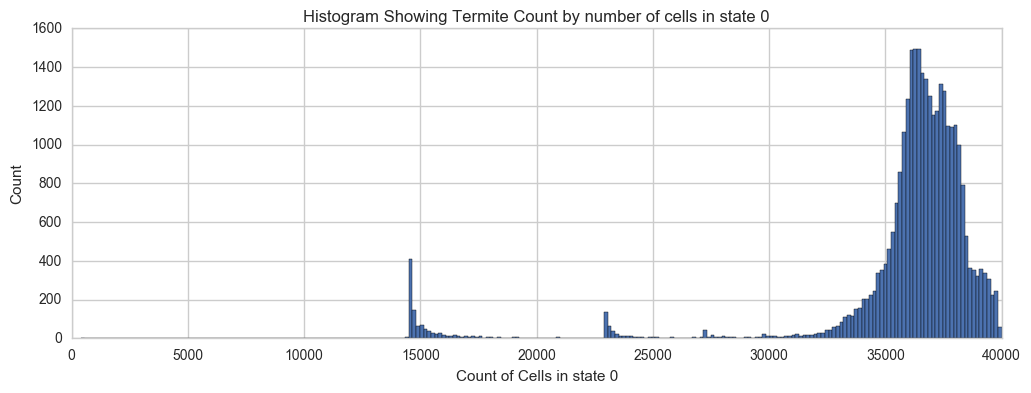

In [47]:
x = '0'
sns.set_style('whitegrid')
plt.figure(figsize=(12,4))
df[(df[x]>0)][x].hist(bins=250)
plt.xlabel('Count of Cells in state 0')
plt.ylabel('Count')
plt.title('Histogram Showing Termite Count by number of cells in state 0')

In [48]:
df.shape

(31202, 21)

Now we can prepare a DataFrame that we will feed in to the clustering model. We will take only the pixel counts and the total number of steps taken.

In [49]:
X = df[df.move_len==16].iloc[:,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,18]]

In [50]:
X.columns

Index([u'0', u'1', u'10', u'11', u'12', u'13', u'14', u'15', u'2', u'3', u'4',
       u'5', u'6', u'7', u'8', u'9', u'steps_taken'],
      dtype='object')

Most of the termites completed all 100000 steps within the grid boundries. 

In [51]:
X[X.steps_taken==100000].steps_taken.count()

29955

Here'a a histogram of the steps taken by ants that took less than 100000 steps.

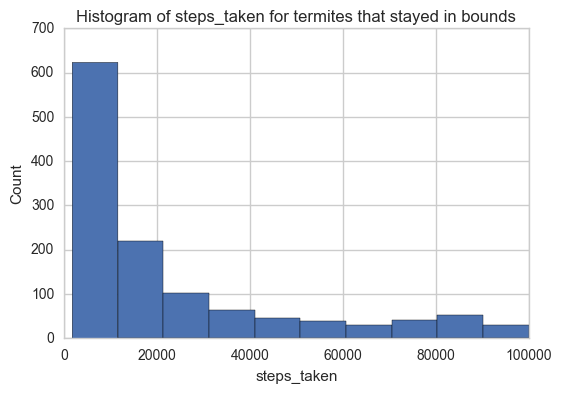

In [247]:
X[X.steps_taken<100000].steps_taken.hist()
plt.title('Histogram of steps_taken for termites that stayed in bounds')
plt.xlabel('steps_taken')
plt.ylabel('Count')

Here's another look at the distribution of cells in state 3 over all termites:

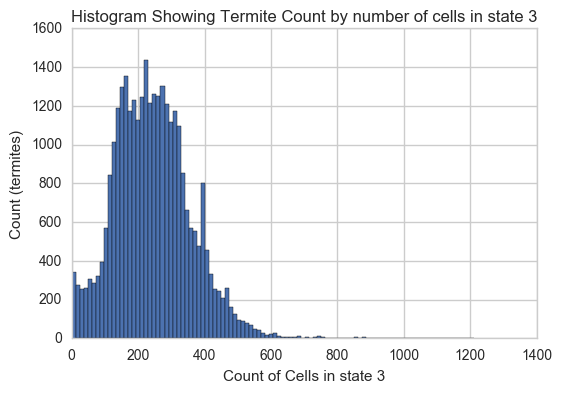

In [54]:
x = '3' #other intereting states: 1, 7, 11, 15
sns.set_style('whitegrid')
#plt.figure(figsize=(12,8))
df[(df[x]>0)][x].hist(bins=100)
plt.xlabel('Count of Cells in state 3')
plt.ylabel('Count (termites)')
plt.title('Histogram Showing Termite Count by number of cells in state 3')

In [55]:
X.shape

(31202, 17)

To cluster the different termites, we can use an unsupervised learning method called clustering. It is "unsupervised" because I don't explicitly tell the model what types termites should be grouped together. Instead, we will tell the model *how many different clusters there are.* Of course, I really don't know how many clusters there should be. I do know from looking at the results that there seem to be many different types of behavior, patterns, sizes and other characteristics. We significantly reduce the complexity of clustering task by training the model on the count of pixels by what state the are in. I'm sure that the model won't be able to pick up on all of the nuances that humans can detect by looking at the images, but I have a feeling that it should be able to do a fairly good job. After we take a look at the individual clusters, we can try to find an optimal number of clusters by minimizing the total number of outliers of all the clusters. Here's [an interesting paper](http://papers.nips.cc/paper/5306-on-integrated-clustering-and-outlier-detection.pdf) on integrated clustering and outlier detection. 

Here's how we set up the clustering model. For the numebr of clusters, let's start with 75. 

In [56]:
k_means = cluster.KMeans(n_clusters=75, random_state=1)

In [57]:
k_means.fit(X, y=None)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=75, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=1, tol=0.0001, verbose=0)

Then we add the cluster number to each termite:

In [58]:
X['clusters'] = k_means.labels_

Here's the breakdown of clusters by number of termites in each cluster:

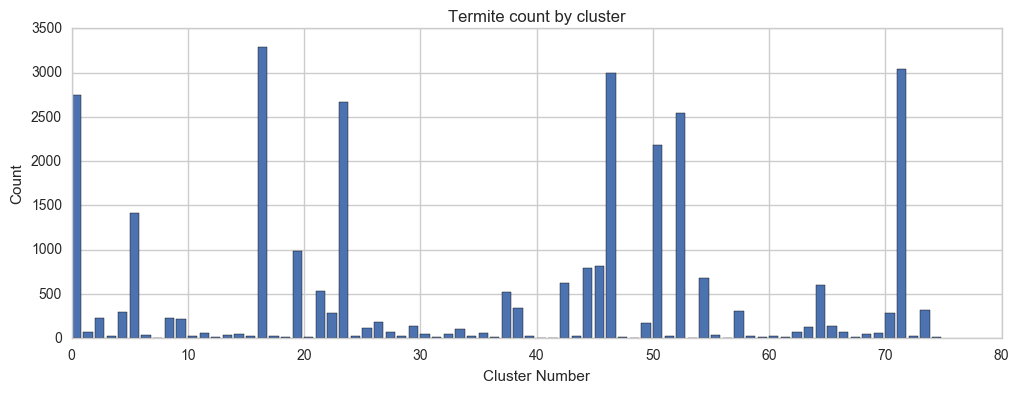

In [59]:
plt.figure(figsize=(12,4))
plt.bar(X.clusters.value_counts().index, X.clusters.value_counts())
plt.xlabel('Cluster Number')
plt.ylabel('Count')
plt.title('Termite count by cluster')

And here is a list of the data shown above:

In [60]:
for x, y in zip(X.clusters.value_counts().index, X.clusters.value_counts()): print(' || cluster_num: ' + str(x) , 'count: ' + str(y), end='  ')

 || cluster_num: 16 count: 3293   || cluster_num: 71 count: 3036   || cluster_num: 46 count: 2993   || cluster_num: 0 count: 2752   || cluster_num: 23 count: 2667   || cluster_num: 52 count: 2540   || cluster_num: 50 count: 2185   || cluster_num: 5 count: 1412   || cluster_num: 19 count: 987   || cluster_num: 45 count: 816   || cluster_num: 44 count: 791   || cluster_num: 54 count: 686   || cluster_num: 42 count: 625   || cluster_num: 64 count: 603   || cluster_num: 21 count: 534   || cluster_num: 37 count: 518   || cluster_num: 38 count: 345   || cluster_num: 73 count: 315   || cluster_num: 57 count: 314   || cluster_num: 4 count: 302   || cluster_num: 22 count: 291   || cluster_num: 70 count: 285   || cluster_num: 8 count: 225   || cluster_num: 2 count: 224   || cluster_num: 9 count: 218   || cluster_num: 26 count: 182   || cluster_num: 49 count: 178   || cluster_num: 65 count: 138   || cluster_num: 29 count: 137   || cluster_num: 63 count: 123   || cluster_num: 25 count: 122   || cl

In [61]:
cluster_dict = {x: y for x, y in zip(X.clusters.value_counts().index, X.clusters.value_counts())}

Now let's have a look at some of the termite clusters. We can use matplotlib and PIL to display multiple images using subplots.

In [202]:
#variables to manage the arrangement and spacing of cluster images
total = 0
rows = 0
im_length = 0

#set variables for cluster images based on cluster size
def set_spacing(files):
    global total
    global rows
    global im_length
    #columns = 6
    total = len(files)
    extras = len(files) % 6
    if extras > 0:
        total += (6 - extras)
    rows = total/6.
    im_length = rows*(20/9.)

#use matplotlib to show images loaded with PIL
def show_images(cluster_num, samples = 0,  files_bool=False, files=None):
    if files_bool==True:
        files1 = np.random.choice(files.index, min(files.shape[0], samples), replace=False)
    if (samples == 0) & (files_bool==False):
        files1 = X[X.clusters==cluster_num].index
    if (samples > 0) & (files_bool==False): 
        files1 = np.random.choice(X[X.clusters==cluster_num].index, min(cluster_dict[cluster_num],samples), replace=False)
    set_spacing(files1)
    plt.figure(figsize = (14,im_length))
    os.chdir(os.path.expanduser('~/Documents/CA_1/imgs/'))
    for num, x in enumerate(files1):
        img = PIL.Image.open(x)
        plt.subplot(rows,6,num+1)
        plt.title(x.split('.')[0])
        plt.axis('off')
        plt.imshow(img)
    print('Cluster #' + str(X.ix[x].clusters) + ' -- Cluster Total: ' + str(cluster_dict[X.ix[x].clusters]))

Cluster #16 -- Cluster Total: 3293


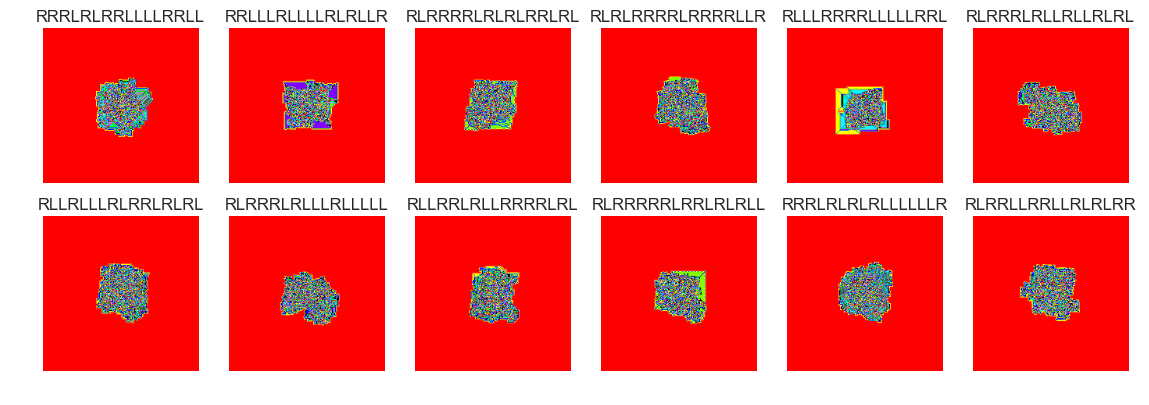

In [149]:
show_images(16, samples=12)

Cluster #46 -- Cluster Total: 2993


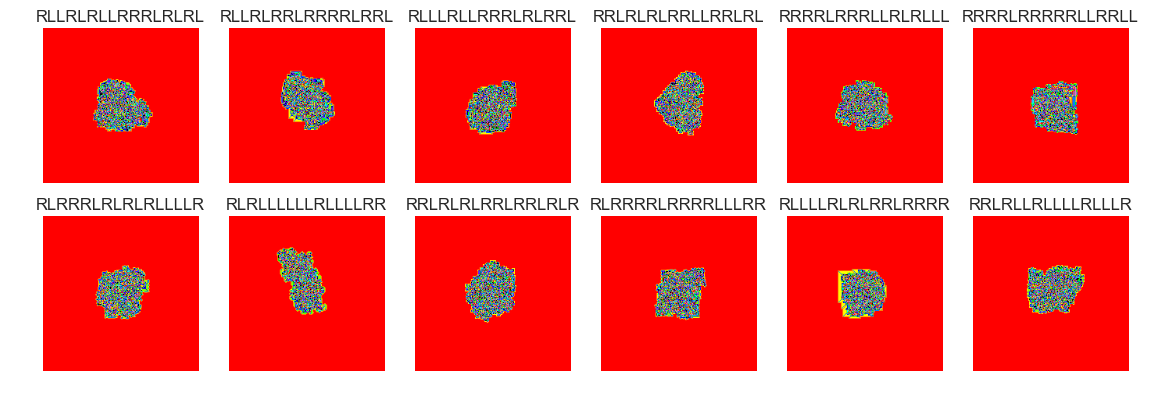

In [79]:
show_images(46, samples=12)

Cluster #51 -- Cluster Total: 25


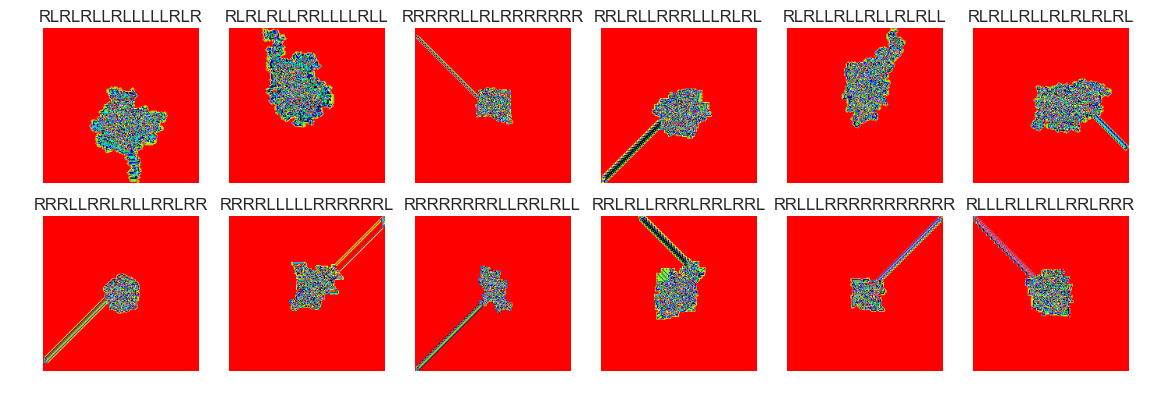

In [80]:
show_images(51, samples=12)

Cluster #18 -- Cluster Total: 12


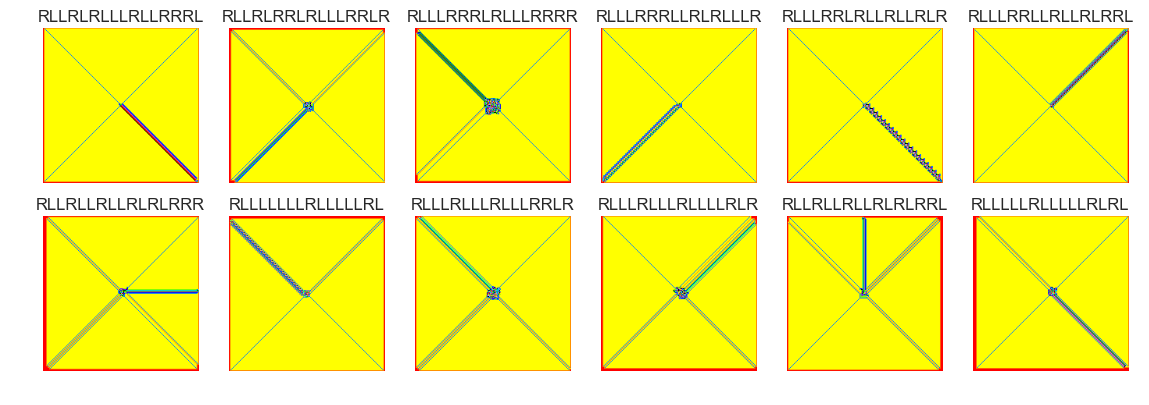

In [81]:
show_images(18, samples=12)

Cluster #4 -- Cluster Total: 302


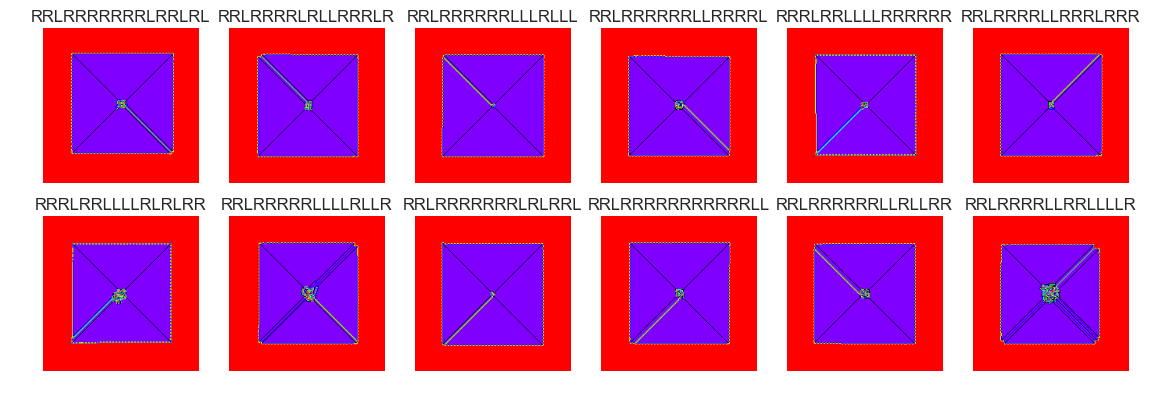

In [82]:
show_images(4, samples=12)

Cluster #5 -- Cluster Total: 1412


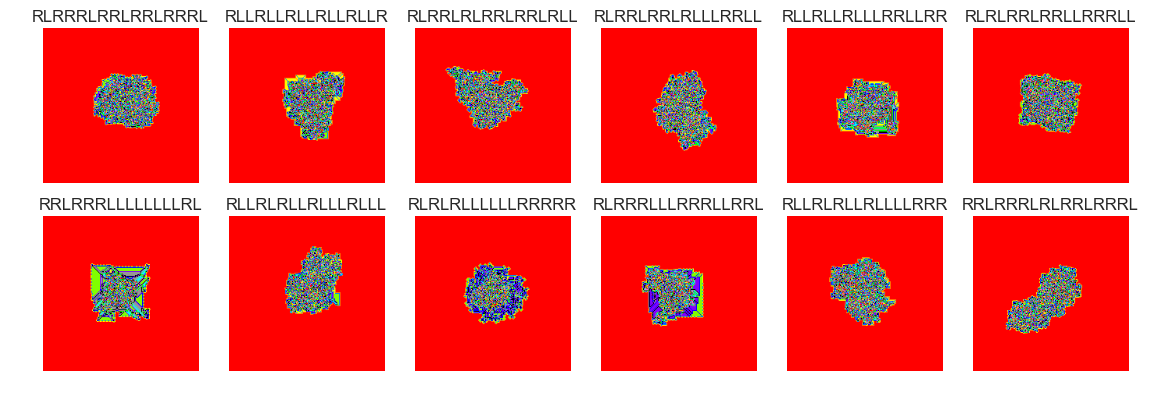

In [83]:
show_images(5, samples=12)

Cluster #6 -- Cluster Total: 35


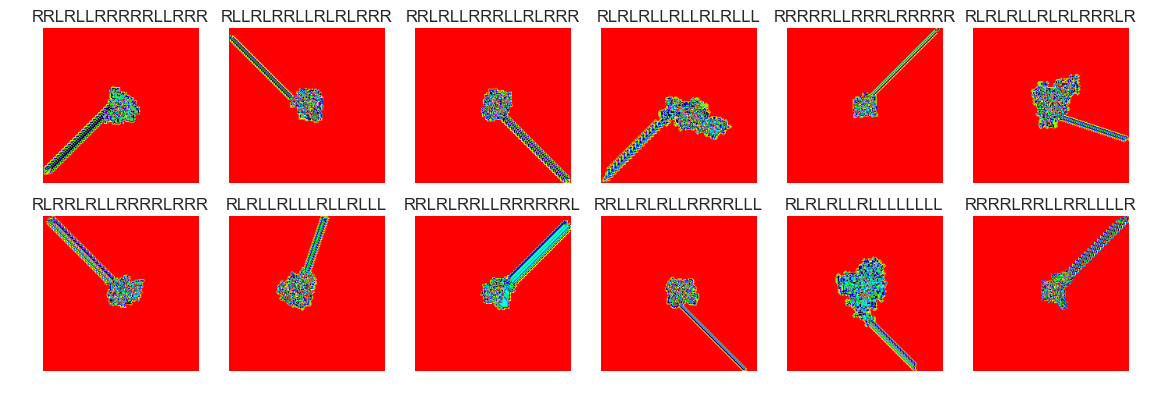

In [84]:
show_images(6, samples=12)

Cluster #9 -- Cluster Total: 218


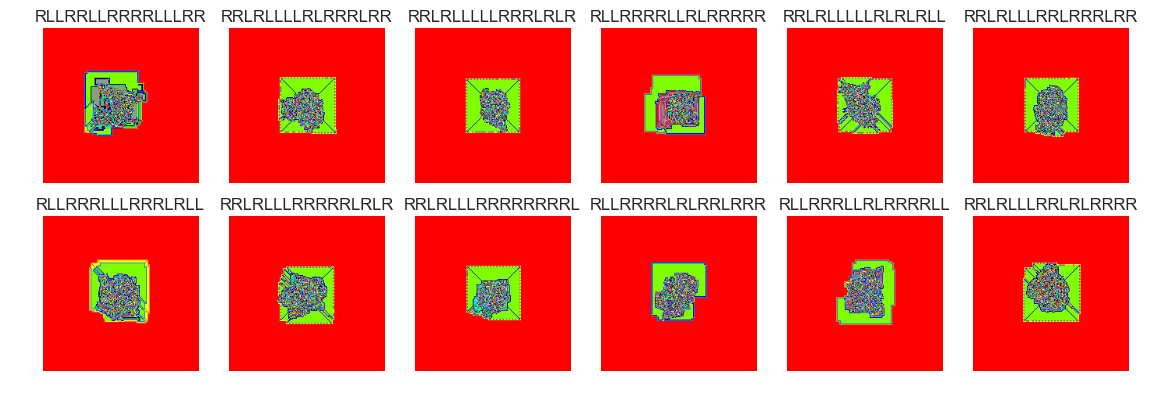

In [85]:
show_images(9, samples=12)

Cluster #12 -- Cluster Total: 11


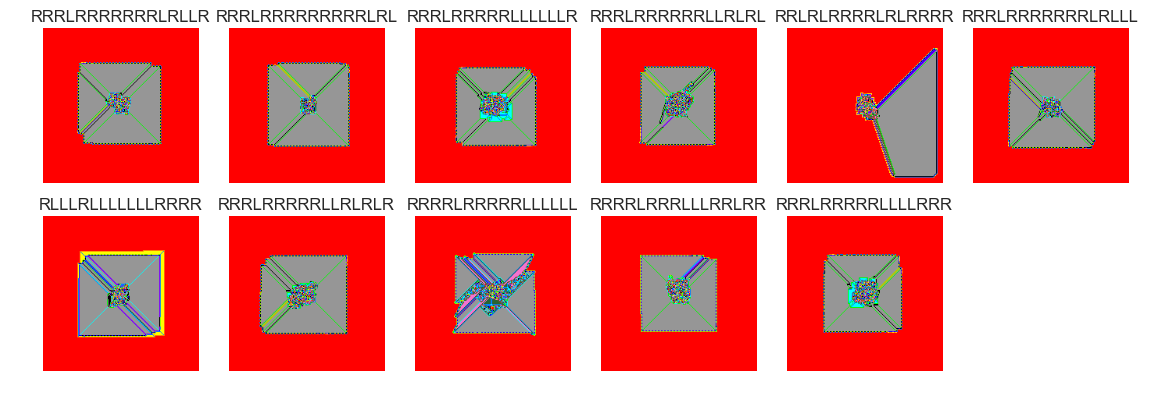

In [86]:
show_images(12, samples=12)

The next four cluster samples are the largest clusters:

Cluster #30 -- Cluster Total: 45


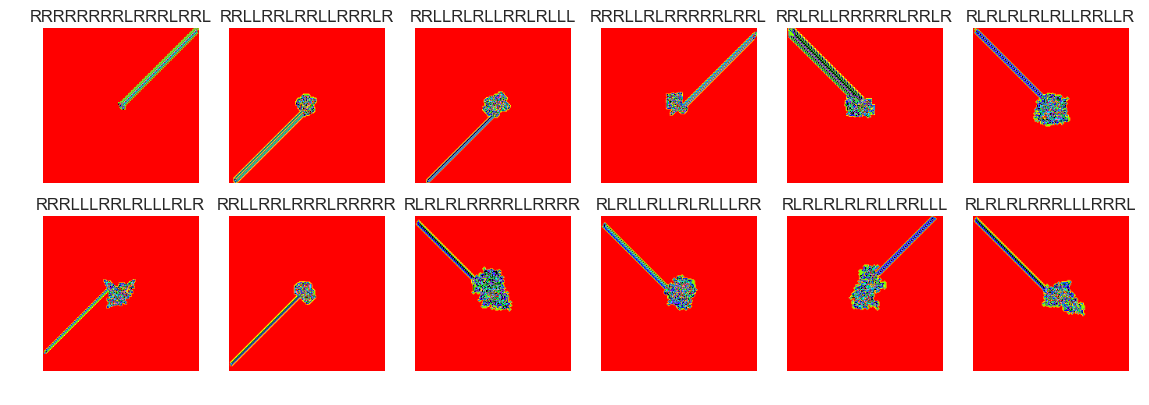

In [87]:
show_images(30, samples=12)

Cluster #30 -- Cluster Total: 45


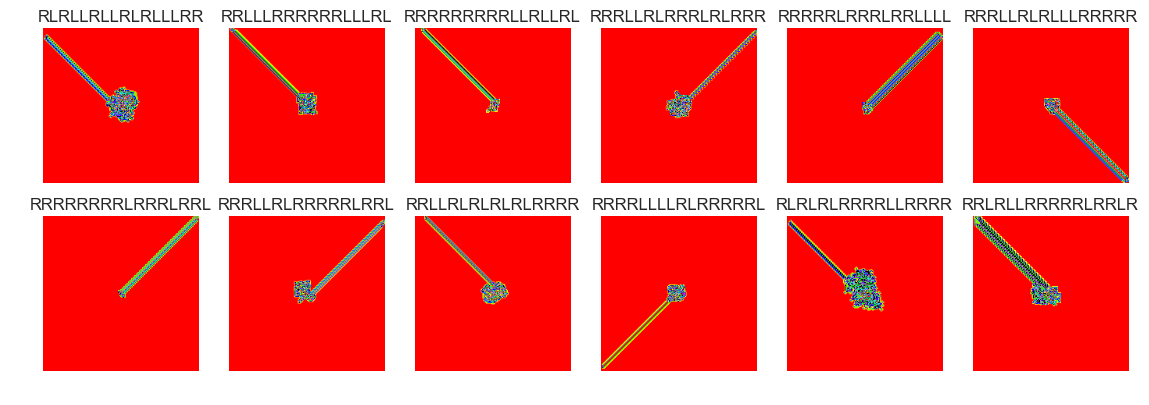

In [88]:
show_images(30, samples=12)

Cluster #0 -- Cluster Total: 2752


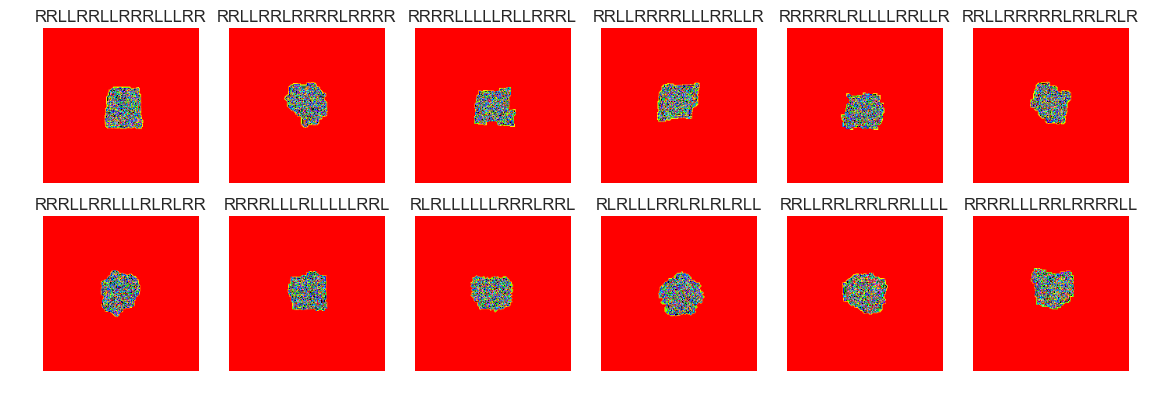

In [89]:
show_images(0, samples=12)

Cluster #30 -- Cluster Total: 45


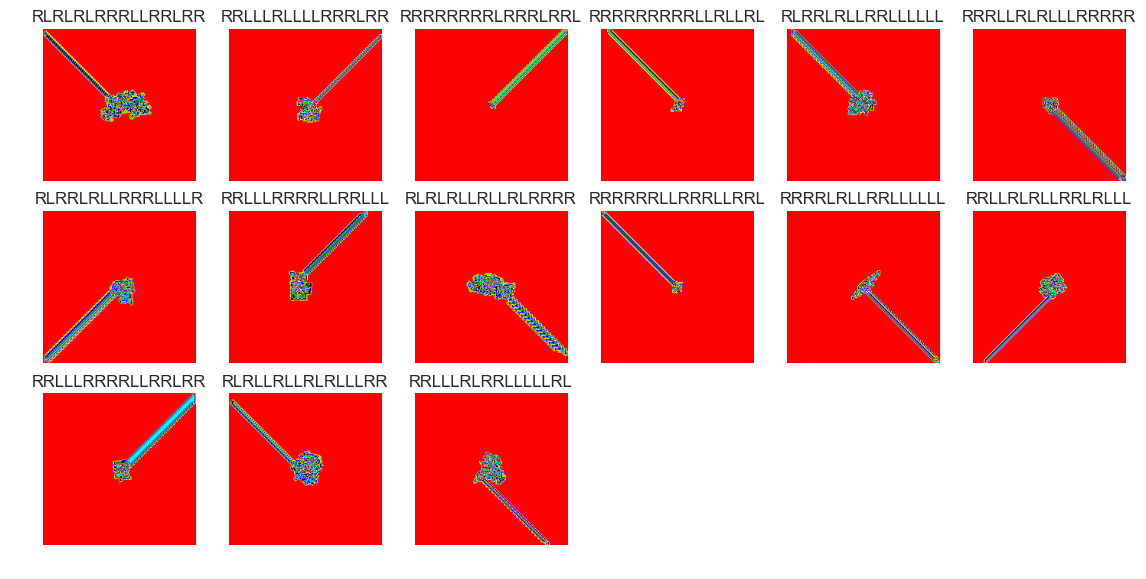

In [90]:
show_images(30, samples=15)

Cluster #63 -- Cluster Total: 123


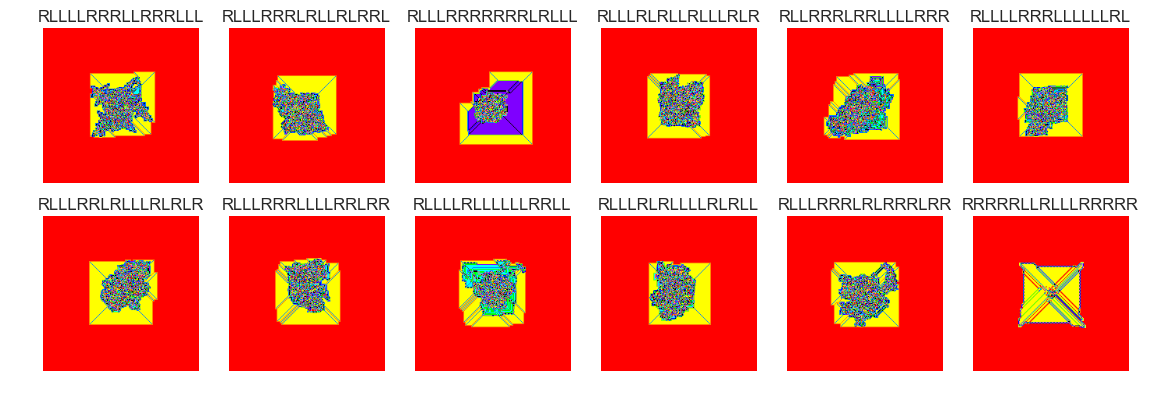

In [91]:
show_images(63, samples=12)

Cluster #60 -- Cluster Total: 30


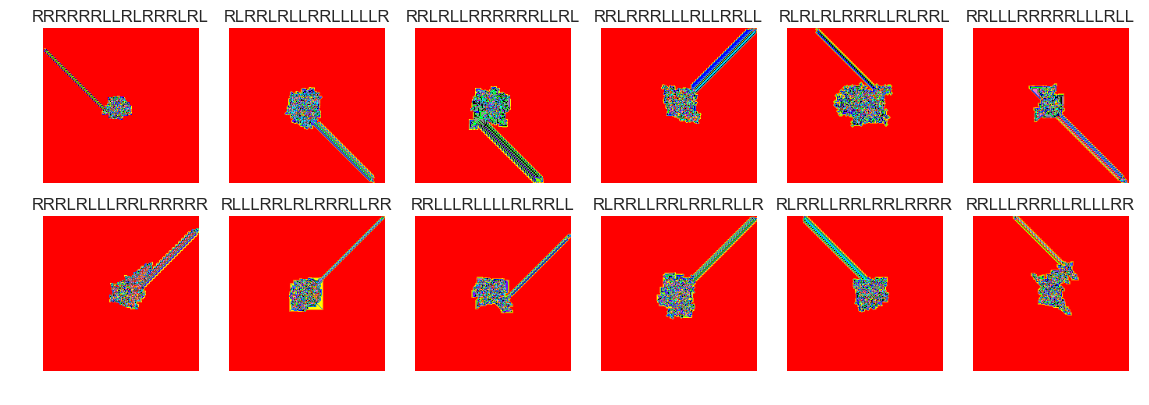

In [92]:
show_images(60, samples=12)

Cluster #59 -- Cluster Total: 10


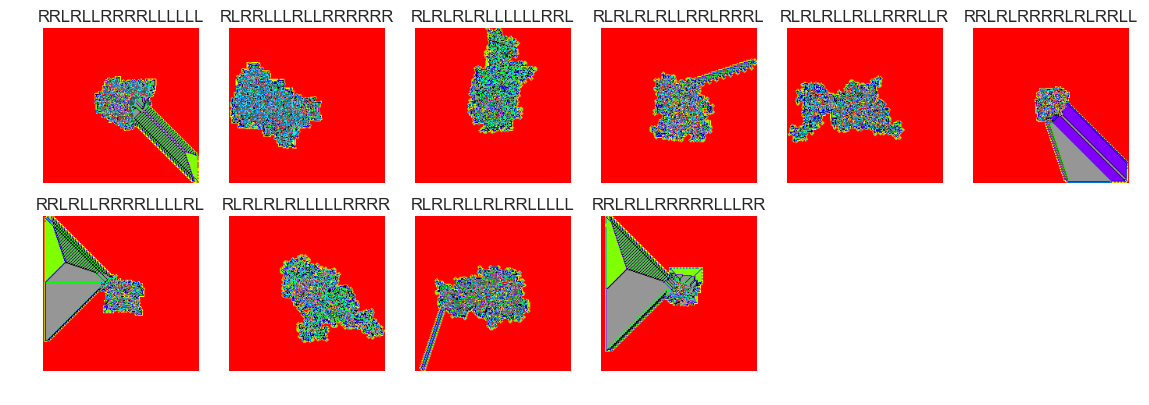

In [93]:
show_images(59, samples=12)

Cluster #57 -- Cluster Total: 314


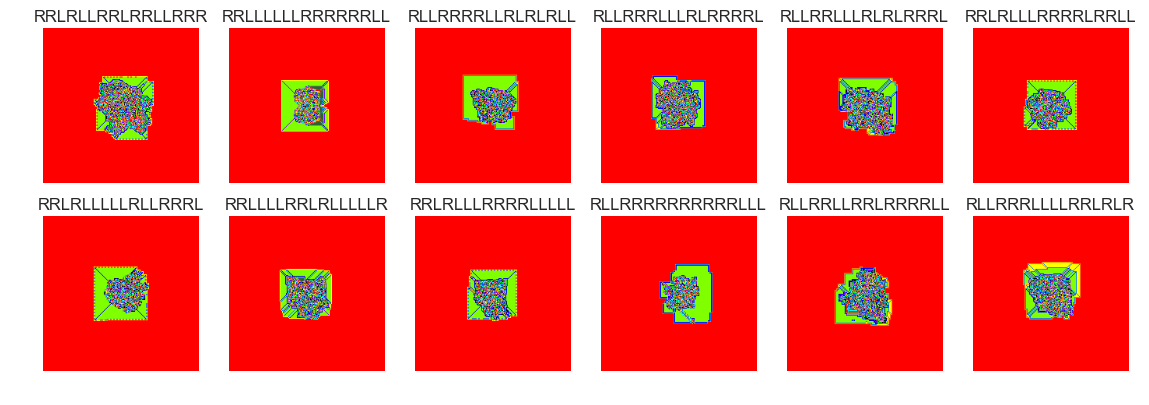

In [94]:
show_images(57, samples=12)

Cluster #56 -- Cluster Total: 1


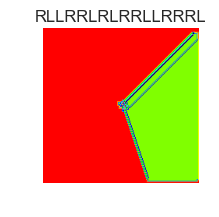

In [95]:
show_images(56, samples=12)

Cluster #55 -- Cluster Total: 38


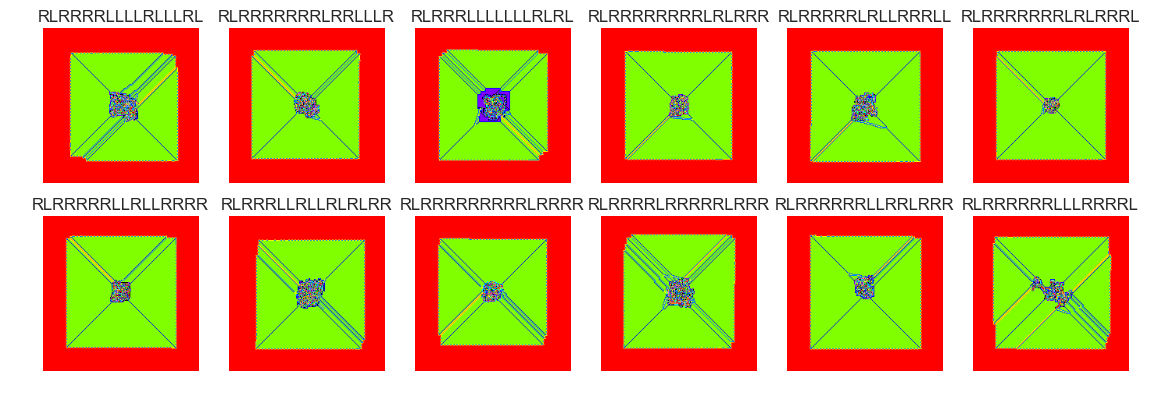

In [96]:
show_images(55, samples=12)

Cluster #54 -- Cluster Total: 686


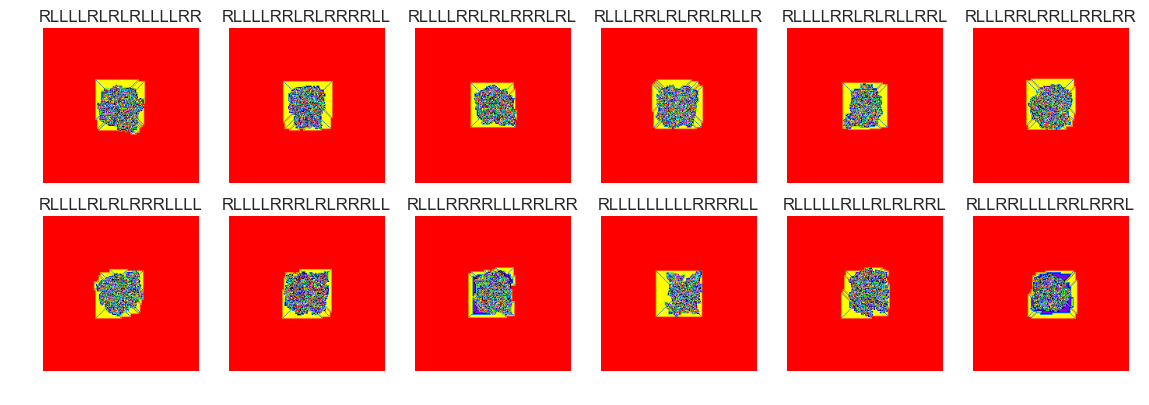

In [97]:
show_images(54, samples=12)

Cluster #53 -- Cluster Total: 8


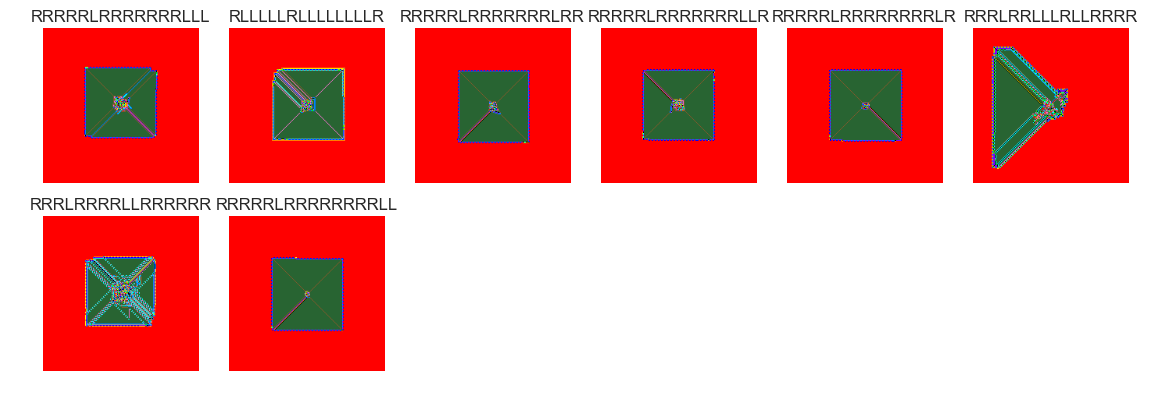

In [98]:
show_images(53, samples=12)

Cluster #52 -- Cluster Total: 2540


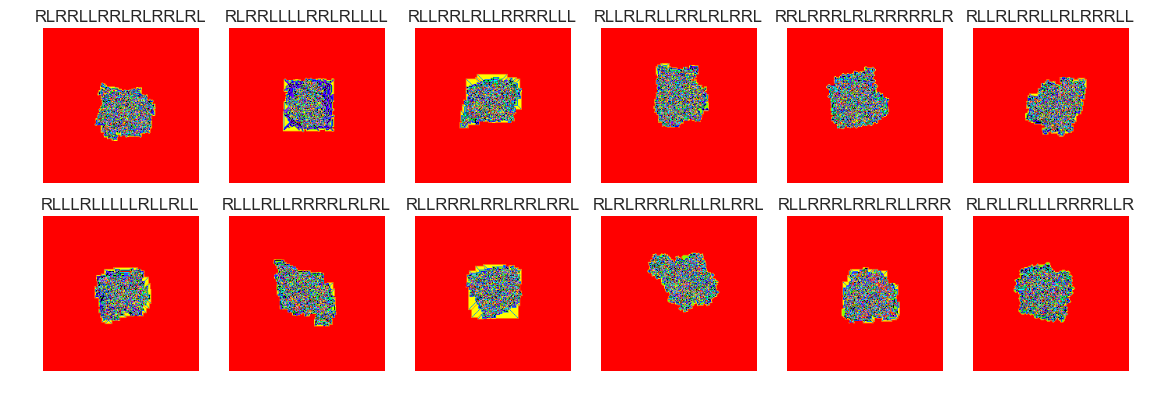

In [131]:
show_images(52, samples=12)

Cluster #51 -- Cluster Total: 25


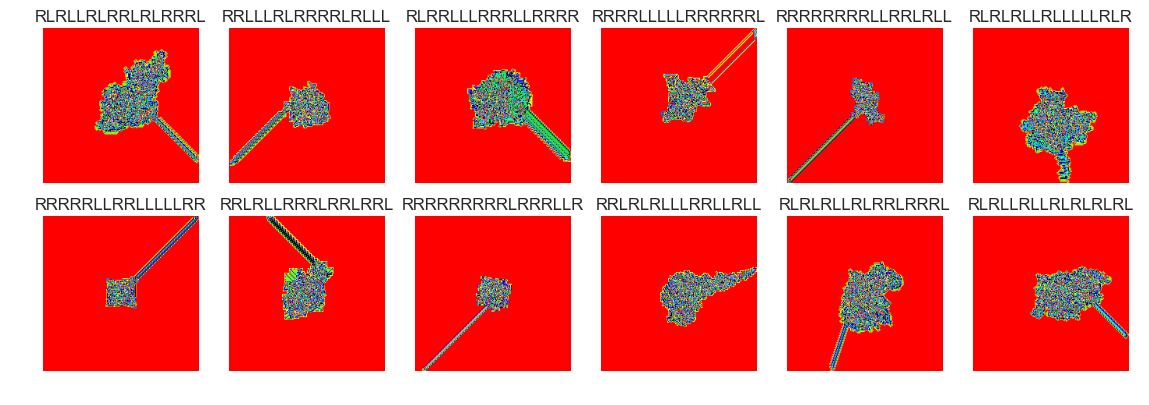

In [100]:
show_images(51, samples=12)

Cluster #50 -- Cluster Total: 2185


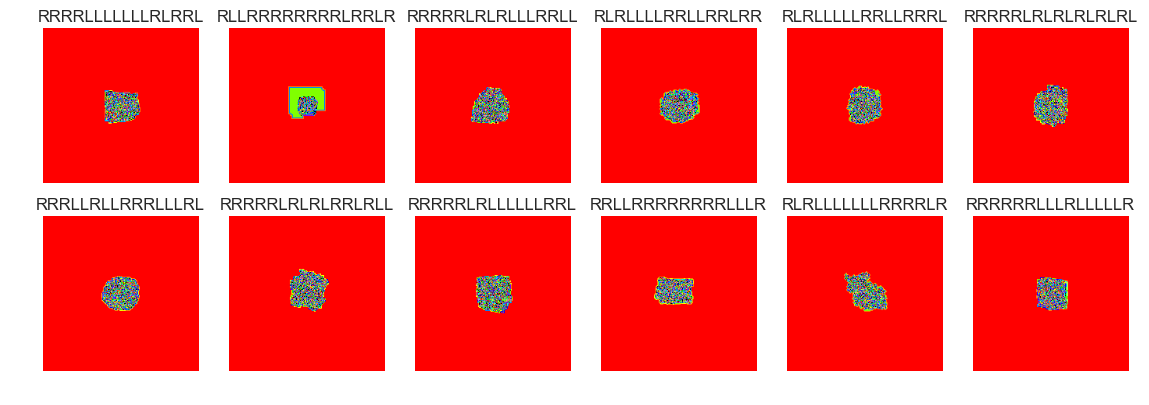

In [101]:
show_images(50, samples=12)

Cluster #49 -- Cluster Total: 178


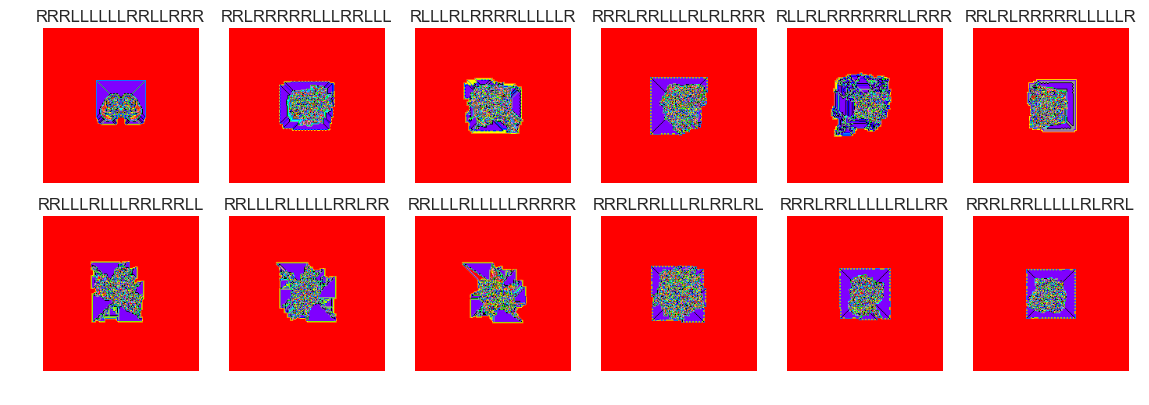

In [102]:
show_images(49, samples=12)

Cluster #48 -- Cluster Total: 3


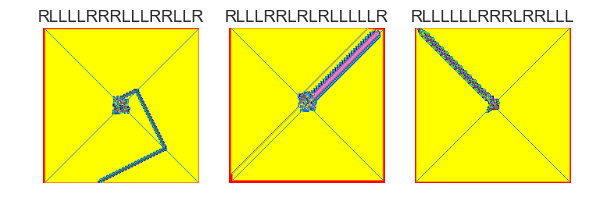

In [103]:
show_images(48, samples=12)

Cluster #47 -- Cluster Total: 11


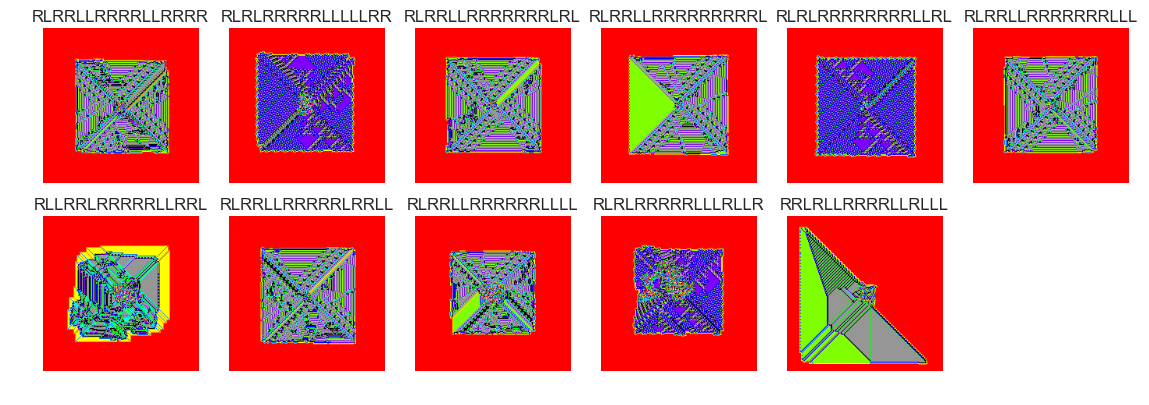

In [104]:
show_images(47, samples=12)

Cluster #46 -- Cluster Total: 2993


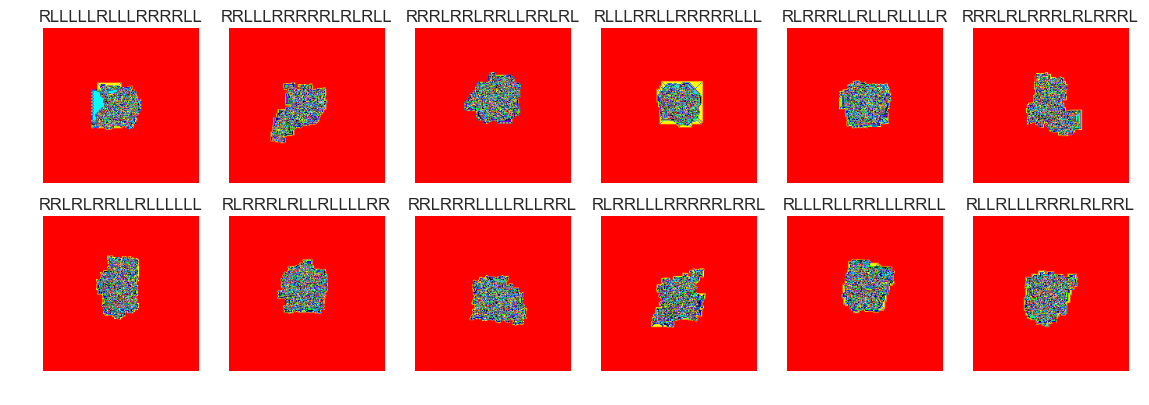

In [105]:
show_images(46, samples=12)

Cluster #45 -- Cluster Total: 816


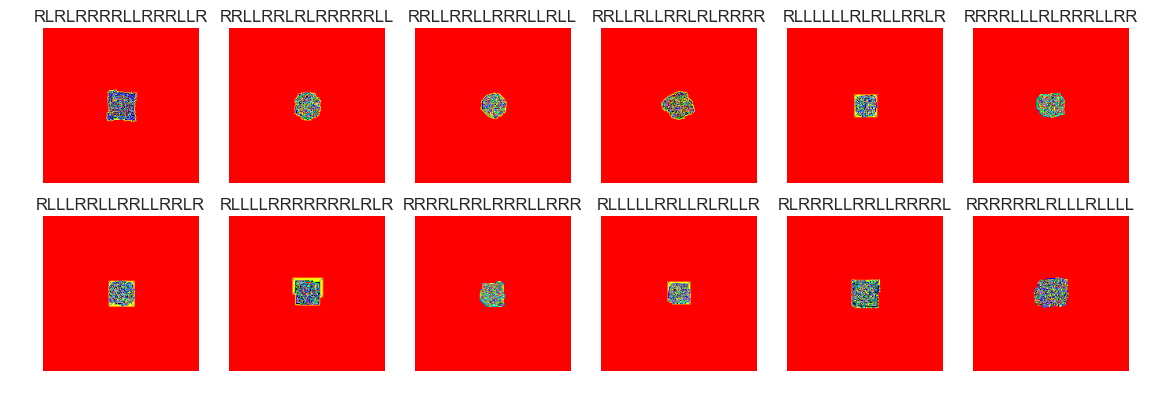

In [106]:
show_images(45, samples=12)

Cluster #44 -- Cluster Total: 791


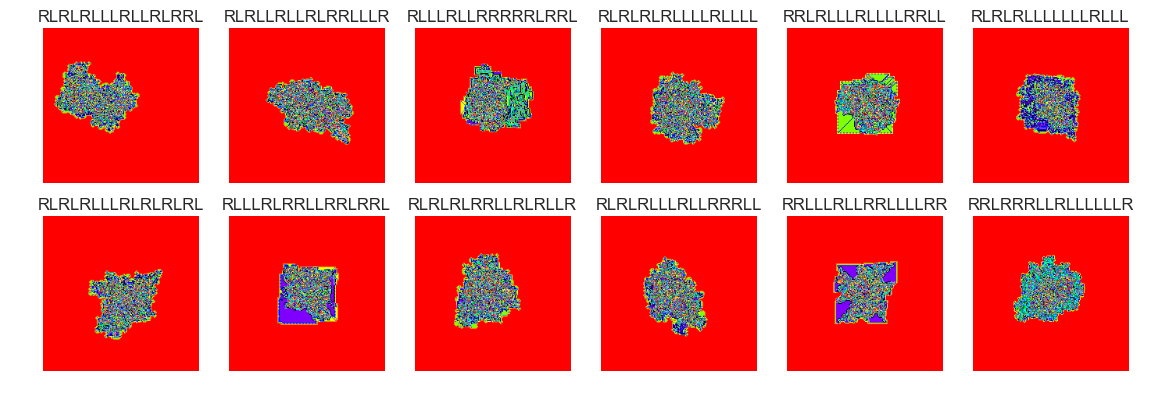

In [107]:
show_images(44, samples=12)

Cluster #43 -- Cluster Total: 30


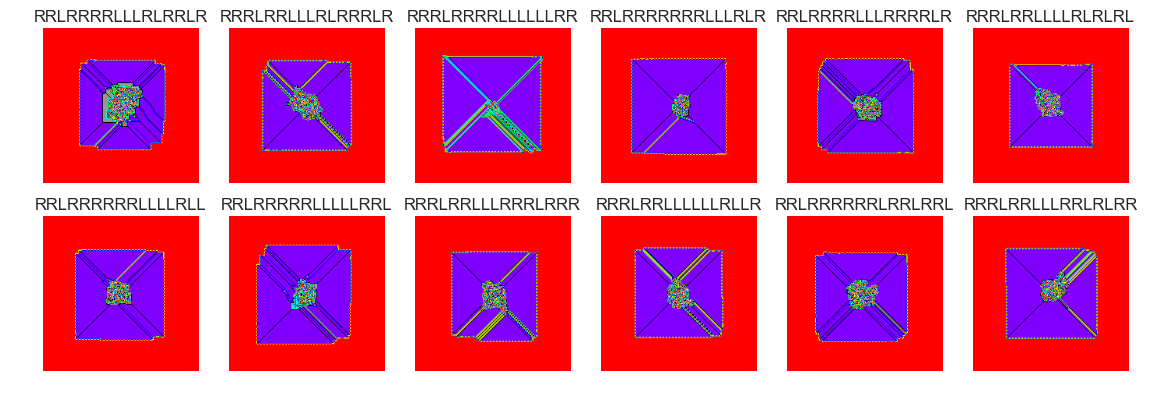

In [108]:
show_images(43, samples=12)

Cluster #42 -- Cluster Total: 625


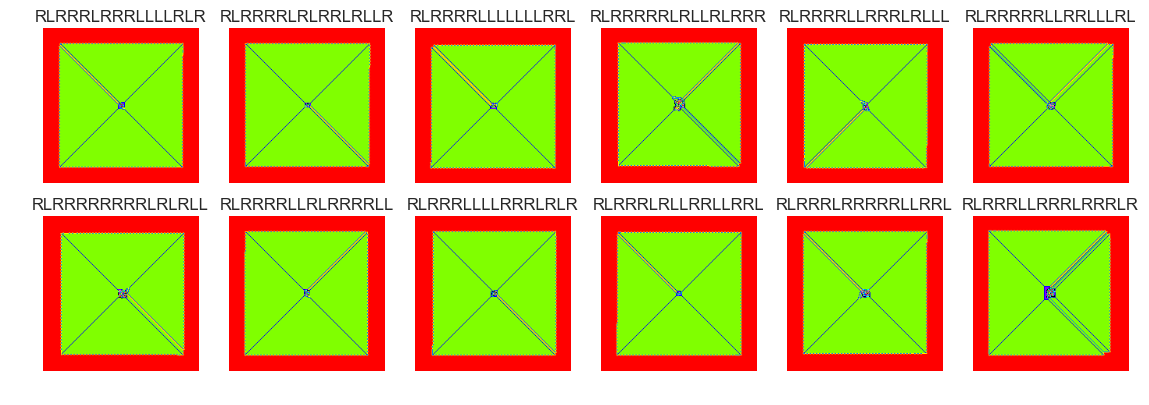

In [109]:
show_images(42, samples=12)

Cluster #41 -- Cluster Total: 6


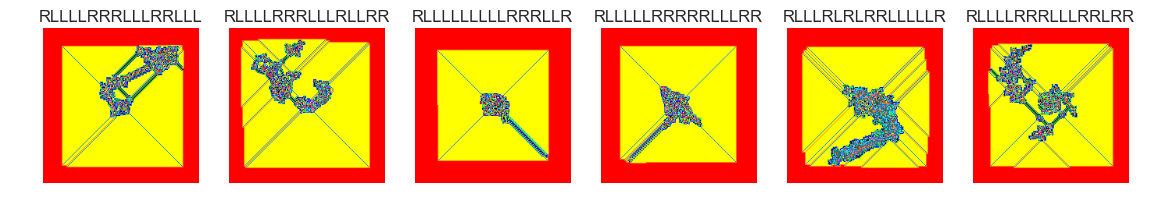

In [110]:
show_images(41, samples=12)

Cluster #40 -- Cluster Total: 6


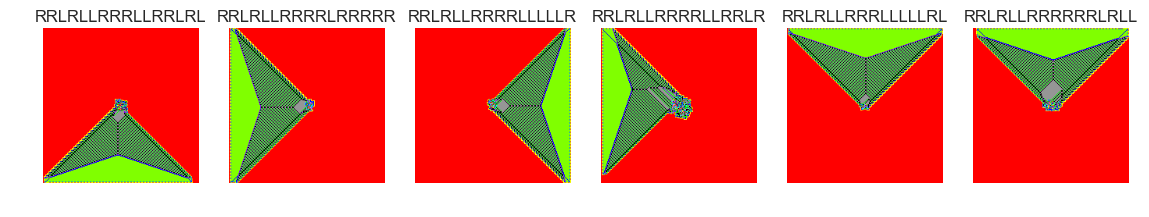

In [111]:
show_images(40, samples=12)

Cluster #39 -- Cluster Total: 26


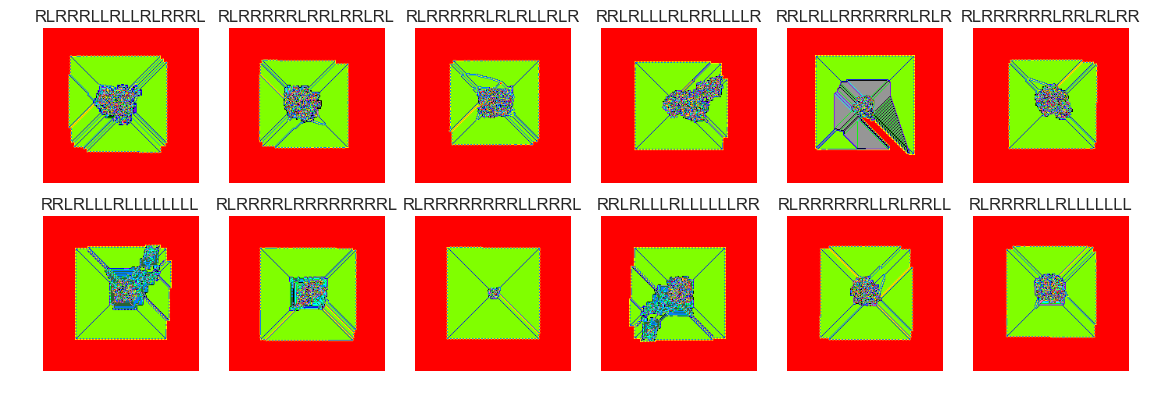

In [112]:
show_images(39, samples=12)

Cluster #38 -- Cluster Total: 345


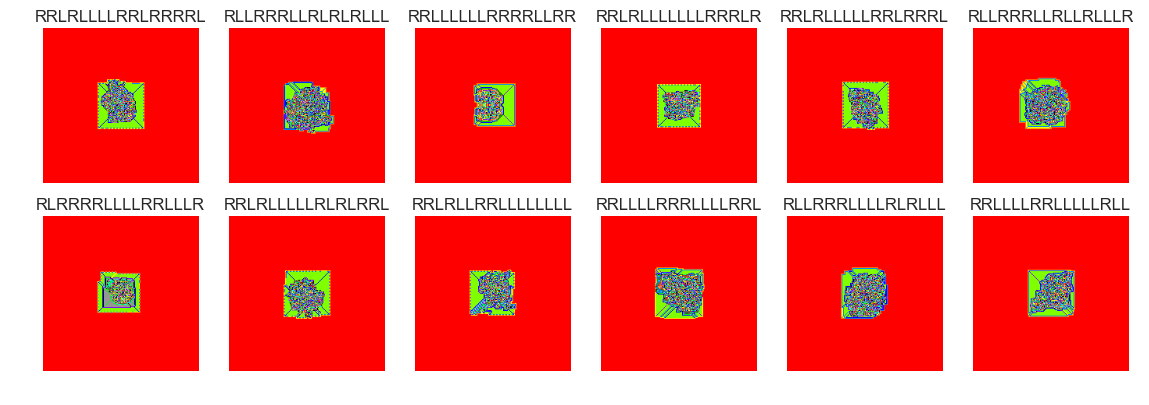

In [113]:
show_images(38, samples=12)

Cluster #37 -- Cluster Total: 518


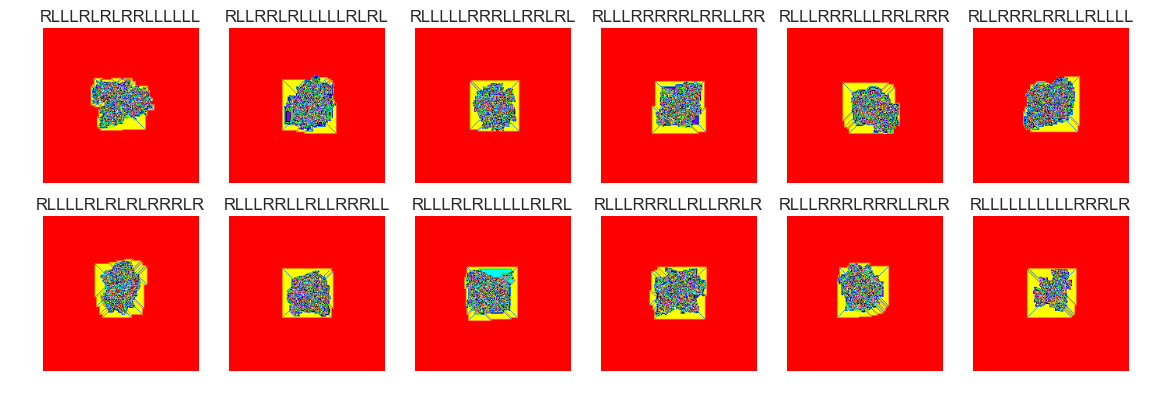

In [114]:
show_images(37, samples=12)

The vast majority of termites seem to form nondescript blobs after 100000 steps. There are perhaps many thousands of termites that didn't yet reach a . Setting the clusters parameter to 75 is probably too high. Many of the groups have similar behaviour. There were several cluster groups that formed 'highways'. It may make more sense to filter out these termites and cluster termites that didn't form highways. 

# Outlier Detection

It could also be interesting to see how many outliers are present in each cluster for various values of k in the k-means algorithm. This may help us choose a more fitting number of clusters by which the termites can be grouped. here's how we could do that: 

In [249]:
from sklearn.ensemble import IsolationForest

In [261]:
X_ = X.loc[X.clusters==37, :] #16

In [275]:
X_ = X.loc[X.clusters==37, :]

In [277]:
clf = IsolationForest(max_samples=100, random_state=rng)
clf.fit(X_)

y_pred_train = clf.predict(X_)


In [278]:
y_pred_train.mean()

0.79922779922779918

The following values gives us the average of the predicted values (1 for inlier, -1 for outlier), so this value doesn't correspond to a percentage accuracy. The accuracy is about 89% (the model determined that 89% of termites in cluster 37 are inliers and the remaining 11% are outliers. 

In [ ]:
X_['anom'] = y_pred_train

In [284]:
X_.anom.value_counts()

 1    466
-1     52
Name: anom, dtype: int64

Let's compare some of the inliers with the outliers: 

Cluster #37 -- Cluster Total: 518


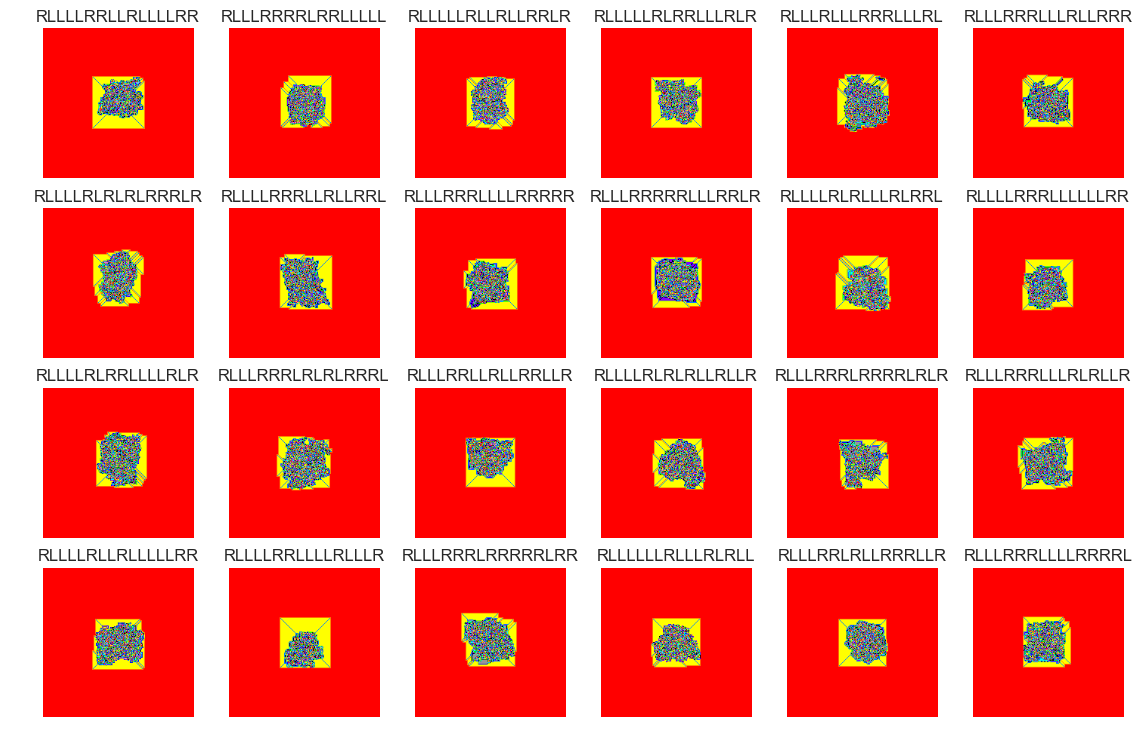

In [245]:
files_normal = X_[X_.anom==(1)]
show_images(0, samples = 24, files_bool=True, files=files_normal)

Cluster #37 -- Cluster Total: 518


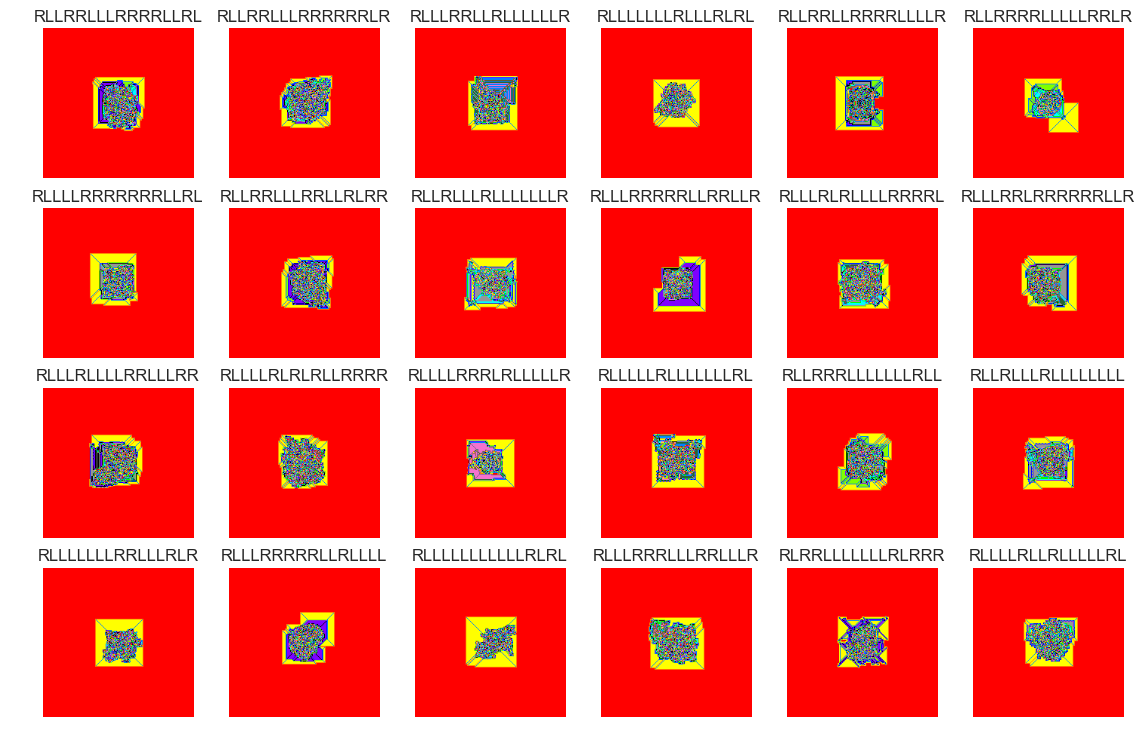

In [246]:
files_abnormal = X_[X_.anom==(-1)]
show_images(0, samples = 24, files_bool=True, files=files_abnormal)

This sample of outliers seems to have slightly different characteristics compared with the inlier sample. This can be seen in the patches of solid colors (pink, purple, teal, grey). 

# Conclusion

Using k-means and Isolation Forests with this set of over 30,000 termites offers a quick and easy way to sort out major trends that these deterministic systems display. As you can see in the cluster samples above, the classification is far from perfect. Some near-identical termites are in different clusters. It would be interesting to tweak some aspects of this experiment in the future:

- Larger number of states (>16)
- More steps (>100000) / bigger grid
- Random "noise" on the grid at step 0
- Variation on the rules
- Segmenting 'highway' termites before clustering